# Анализ реальных данных,полученных с помощью Google Cloud APIs, для популярного YouTube канала

# Введение

В данном исследовании проанализирован один из самых популярных русскоязычных YouTube каналов (по количеству подписчиков) - "А4". Было бы интересно посмотреть закономерности у характеристик видео и получить общее представление о всех видео с момента выпуска первого ролика, а также проверить гипотезы выдвинутые относительно популярности канала.

# Получение данных с использованием YouTube API

In [1]:
# Google API
from googleapiclient.discovery import build 

import pandas as pd
from IPython.display import JSON
from dateutil import parser

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [55]:
api_key = 'key'

In [3]:
# Create list of channels or just one channel
channel_ids = ['UC2tsySbe9TNrI-xh2lximHA',
              # more channels here
              ]

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [5]:
# def get_channel_stats(channel_ids, youtube):

def get_channel_stats(channel_ids, youtube):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []

    request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=','.join(channel_ids)
    )
    response = request.execute()

    for item in response['items']:
         data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'total_videos': item['statistics']['videoCount'],
                'playlist_id': item['contentDetails']['relatedPlaylists']['uploads']
                }
         all_data.append(data) 
    return(pd.DataFrame(all_data))       

In [6]:
channel_stats = get_channel_stats(channel_ids, youtube)

In [7]:
channel_stats

,channelName,subscribers,views,total_videos,playlist_id
0,A4,44300000,20509412475,718,UU2tsySbe9TNrI-xh2lximHA


После получения JSON файла были выбраны параметры для составления таблицы channel_stats, в которой отражаются основные характеристики канала, а также playlist_id, с помощью котрого получим доступ ко всем видео на канале

In [8]:
playlist_id = 'UU2tsySbe9TNrI-xh2lximHA'

def get_video_ids(playlist_id, youtube):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId="UU2tsySbe9TNrI-xh2lximHA",
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet, contentDetails",
            playlistId="UU2tsySbe9TNrI-xh2lximHA",
            maxResults = 50,
            pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return(video_ids) 

In [9]:
video_ids = get_video_ids(playlist_id, youtube)

In [10]:
len(video_ids)

719

Получен список, сожержащий id всех видео

In [11]:
def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [12]:
video_df = get_video_details(youtube, video_ids)
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,rvensYEWq9w,A4,ЧТО-ТО Живет в Нашем ПОДВАЛЕ !,В этом ролике мы нашли мусорного монстра в под...,"[ЧТО-ТО Живет в Нашем ПОДВАЛЕ !, что-то живет ...",2023-02-13T12:00:38Z,5272404,288239,None,17988,PT23M6S,hd,true
1,sTM-2bVFr70,A4,Превратили ДОМ в БАТУТНЫЙ ПАРК !,Чипсы ЛАВА ЛАВА в теперь МАГНИТЕ ! Беги в ближ...,"[Превратили ДОМ в БАТУТНЫЙ ПАРК !, превратили ...",2023-02-11T09:00:37Z,11086190,689557,None,53207,PT31M14S,hd,true
2,Zva7AW4Xpbw,A4,12 Способов Пронести СЛАДОСТИ в ТЮРЬМУ !,В этом ролике нашу подругу Риви посадили в тюр...,"[12 Способов Пронести СЛАДОСТИ в ТЮРЬМУ, 12 сп...",2023-02-08T12:51:18Z,10564586,377634,None,27365,PT29M54S,hd,true
3,R86y0a33m74,A4,Едим Еду на Каждую Букву АЛФАВИТА !,Скачивай Genshin Impact - https://hoyo.link/a9...,"[Едим Еду на Каждую Букву АЛФАВИТА !, ЕДИМ ПО ...",2023-02-06T13:09:12Z,10416025,502868,None,70029,PT32M38S,hd,true
4,ujA2CN1AIEc,A4,СУПЕРЗЛОДЕЙ от Рождения до Смерти за 24 часа !...,Проголодались? Го в приложение Бургер Кинг! \n...,[СУПЕРЗЛОДЕЙ от Рождения до Смерти за 24 часа ...,2023-02-04T09:00:28Z,15714441,459102,None,26441,PT33M32S,hd,true


In [13]:
video_df.shape

(719, 13)

Получен датафрейм с информацией по каждому видео

# Предварительная обработка данных

In [14]:
video_df.shape

(719, 13)

In [15]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,rvensYEWq9w,A4,ЧТО-ТО Живет в Нашем ПОДВАЛЕ !,В этом ролике мы нашли мусорного монстра в под...,"[ЧТО-ТО Живет в Нашем ПОДВАЛЕ !, что-то живет ...",2023-02-13T12:00:38Z,5272404,288239,None,17988,PT23M6S,hd,true
1,sTM-2bVFr70,A4,Превратили ДОМ в БАТУТНЫЙ ПАРК !,Чипсы ЛАВА ЛАВА в теперь МАГНИТЕ ! Беги в ближ...,"[Превратили ДОМ в БАТУТНЫЙ ПАРК !, превратили ...",2023-02-11T09:00:37Z,11086190,689557,None,53207,PT31M14S,hd,true
2,Zva7AW4Xpbw,A4,12 Способов Пронести СЛАДОСТИ в ТЮРЬМУ !,В этом ролике нашу подругу Риви посадили в тюр...,"[12 Способов Пронести СЛАДОСТИ в ТЮРЬМУ, 12 сп...",2023-02-08T12:51:18Z,10564586,377634,None,27365,PT29M54S,hd,true
3,R86y0a33m74,A4,Едим Еду на Каждую Букву АЛФАВИТА !,Скачивай Genshin Impact - https://hoyo.link/a9...,"[Едим Еду на Каждую Букву АЛФАВИТА !, ЕДИМ ПО ...",2023-02-06T13:09:12Z,10416025,502868,None,70029,PT32M38S,hd,true
4,ujA2CN1AIEc,A4,СУПЕРЗЛОДЕЙ от Рождения до Смерти за 24 часа !...,Проголодались? Го в приложение Бургер Кинг! \n...,[СУПЕРЗЛОДЕЙ от Рождения до Смерти за 24 часа ...,2023-02-04T09:00:28Z,15714441,459102,None,26441,PT33M32S,hd,true


In [16]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [17]:
video_df.isnull().sum()

video_id            0
channelTitle        0
title               0
description         0
tags                5
publishedAt         0
viewCount           0
likeCount           0
favouriteCount    719
commentCount        0
duration            0
definition          0
caption             0
dtype: int64

В датафрейме video_df в двух столбцах есть отсутсвующие данные. Данные о добавлении видео в избранное отсутсвуют у всех видео, поэтому этот столбец следует убрать. У пяти видео отсутсвуют теги - для этого исследования некритично

In [18]:
video_df = video_df.drop('favouriteCount', axis = 1)
video_df.shape

(719, 12)

In [19]:
video_df.dtypes

video_id        object
channelTitle    object
title           object
description     object
tags            object
publishedAt     object
viewCount       object
likeCount       object
commentCount    object
duration        object
definition      object
caption         object
dtype: object

Видно, что у всех столбцов тип данных object. Изменим на подходящий

In [20]:
numeric_cols = ['viewCount', 'likeCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, axis = 1, errors = 'coerce')

Количественные показатели приведены к числовому типу

In [21]:
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

Дата публикации приведена к формату datetime

In [22]:
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

Продолжительность видео переведена в секунды и добавлен столбец с названием дня недели, в который опубликовано видео

In [23]:
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

Добавлен столбец с количесвтом тегов

In [24]:
video_df.dtypes

video_id                             object
channelTitle                         object
title                                object
description                          object
tags                                 object
publishedAt         datetime64[ns, tzutc()]
viewCount                             int64
likeCount                             int64
commentCount                          int64
duration                             object
definition                           object
caption                              object
pushblishDayName                     object
durationSecs                        float64
tagCount                              int64
dtype: object

In [25]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,rvensYEWq9w,A4,ЧТО-ТО Живет в Нашем ПОДВАЛЕ !,В этом ролике мы нашли мусорного монстра в под...,"[ЧТО-ТО Живет в Нашем ПОДВАЛЕ !, что-то живет ...",2023-02-13 12:00:38+00:00,5272404,288239,17988,PT23M6S,hd,true,Monday,1386.0,16
1,sTM-2bVFr70,A4,Превратили ДОМ в БАТУТНЫЙ ПАРК !,Чипсы ЛАВА ЛАВА в теперь МАГНИТЕ ! Беги в ближ...,"[Превратили ДОМ в БАТУТНЫЙ ПАРК !, превратили ...",2023-02-11 09:00:37+00:00,11086190,689557,53207,PT31M14S,hd,true,Saturday,1874.0,19
2,Zva7AW4Xpbw,A4,12 Способов Пронести СЛАДОСТИ в ТЮРЬМУ !,В этом ролике нашу подругу Риви посадили в тюр...,"[12 Способов Пронести СЛАДОСТИ в ТЮРЬМУ, 12 сп...",2023-02-08 12:51:18+00:00,10564586,377634,27365,PT29M54S,hd,true,Wednesday,1794.0,13
3,R86y0a33m74,A4,Едим Еду на Каждую Букву АЛФАВИТА !,Скачивай Genshin Impact - https://hoyo.link/a9...,"[Едим Еду на Каждую Букву АЛФАВИТА !, ЕДИМ ПО ...",2023-02-06 13:09:12+00:00,10416025,502868,70029,PT32M38S,hd,true,Monday,1958.0,21
4,ujA2CN1AIEc,A4,СУПЕРЗЛОДЕЙ от Рождения до Смерти за 24 часа !...,Проголодались? Го в приложение Бургер Кинг! \n...,[СУПЕРЗЛОДЕЙ от Рождения до Смерти за 24 часа ...,2023-02-04 09:00:28+00:00,15714441,459102,26441,PT33M32S,hd,true,Saturday,2012.0,23


In [26]:
video_df.shape

(719, 15)

# EDA и визуализация

## Описательная статистика

In [27]:
video_df.describe()

,viewCount,likeCount,commentCount,durationSecs,tagCount
count,7.190000e+02,7.190000e+02,719.000000,719.000000,719.000000
mean,2.853393e+07,1.437779e+06,85076.613352,1454.063978,17.920723
std,1.520713e+07,8.802258e+05,82768.543645,636.403880,5.245038
min,0.000000e+00,1.500000e+01,0.000000,0.000000,0.000000
25%,1.677996e+07,7.262590e+05,31529.000000,1323.000000,15.000000
50%,2.736806e+07,1.294135e+06,61709.000000,1536.000000,18.000000
75%,3.803712e+07,1.981992e+06,109922.000000,1709.000000,21.000000
max,1.082691e+08,4.665422e+06,948569.000000,12960.000000,39.000000


In [28]:
video_df.loc[video_df.durationSecs == 0]

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
688,c6WnuMhVwC4,A4,БЫСТРЕЕ СЮДА!),донатик -- http://www.donationalerts.ru/r/a4om...,None,2016-09-28 14:00:22+00:00,0,15,0,P0D,sd,false,Wednesday,0.0,0


In [29]:
video_df.sort_values(by = 'durationSecs', ascending = False).head(1)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
75,0s8475nQ_qU,A4,Выбираем ЛУЧШИЙ РОЛИК на канале А4 !,Выберем самый лучший ролик на канале А4 !\nTel...,None,2022-08-06 12:57:12+00:00,16773966,641247,30845,PT3H36M,hd,false,Saturday,12960.0,0


In [30]:
video_df.drop(video_df.index[video_df['video_id'] == '0s8475nQ_qU'], inplace=True)
video_df.drop(video_df.index[video_df['video_id'] == 'c6WnuMhVwC4'], inplace=True)

В выборку попало видео, у котрого нет просмотров. Эта анамалия объясняется тем, что видео является прерванной трансляцией. Вероятно, по техническим причинам трансяция не закончилась в штатном режиме и осталась в общем списке видео. Из датафрейма эта строка будет удалена, так как не несет в себе необходимой информации. Также удалено единственное видео длительностью 3 часа, так как оно тоже является выбросом, т.е. находидся далеко от общего облака распределения 

In [31]:
video_df.describe()

,viewCount,likeCount,commentCount,durationSecs,tagCount
count,7.170000e+02,7.170000e+02,717.000000,717.000000,717.000000
mean,2.859013e+07,1.440895e+06,85270.906555,1440.044630,17.970711
std,1.518451e+07,8.793059e+05,82798.026789,467.005378,5.166013
min,1.129902e+06,5.338900e+04,0.000000,16.000000,0.000000
25%,1.684630e+07,7.274390e+05,31550.000000,1327.000000,15.000000
50%,2.737740e+07,1.295954e+06,62041.000000,1536.000000,18.000000
75%,3.804675e+07,1.984578e+06,110174.000000,1708.000000,21.000000
max,1.082691e+08,4.665422e+06,948569.000000,3729.000000,39.000000


В большинстве случаев видео не набирали просмотры больше 80 миллионов. Чаще всего видео просматривают 27 млн раз. 
Средняя продолжительность видео - 24 минуты. 
В среднем вмдео набирают 1,4 млн лайков, что в 20 раза меньше, чем среднее количество просмотров. (на 20 просмотра приходится 1 лайк)
Под видео Влада А4 в среднем оставляют 85 тыс. комментариев. Максимальное значение - 948 тыс. (или почти 1 млн).

## Распределение просмотров

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

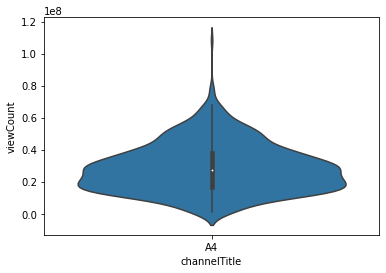

In [32]:
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

Есть отскивающая точка - видео набравшие больше 100 миллионов просмотров.

## Лучшие видео

C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128123 (\N{GHOST}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


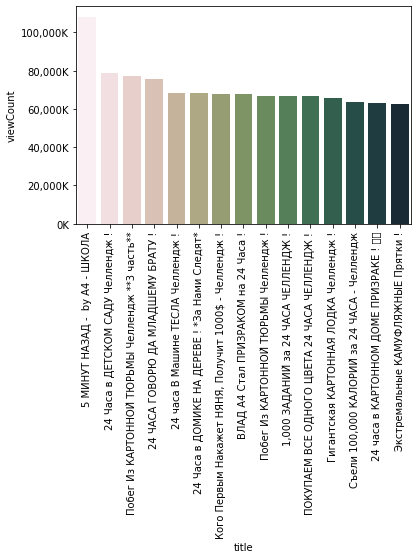

In [54]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:15], palette = 'ch:r=-0.8, l= 0.95')
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

В топ-15 популярных видео можем увидеть что большинство роликов набрали одинаковое количество просмотров (~ 65 миллионов). Самое популярное видео, как уже отмечалось ранее, набрало более 100 млн просмотров. Это музыкальное видео, поэтому можем связать такое количество с тем, что пользователи пересматривали видео несколько раз. Помимо него самыми популярными не музыкальными видео оказались 24 часа в детском саду челлендж, Побеш из картонной тюрьмы челлендж и 24 часа говорю да младшему брату.

## Видео с наименьшим числом просмотров

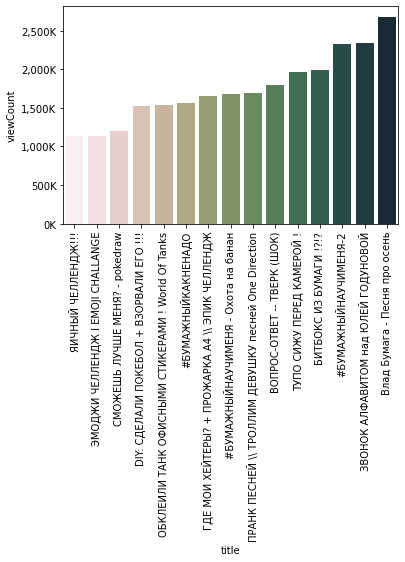

In [53]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:15], palette = 'ch:r=-0.8, l= 0.95')
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

Минимальное количесвто просмотров, около 1 100 000 просмотров, набрали три видео

## Продолжительность видео

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

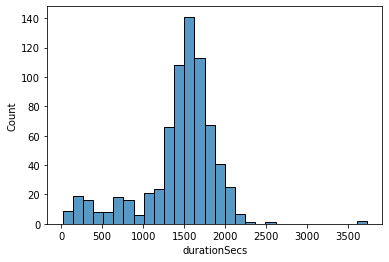

In [37]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

Правктически все видео продолжительнотью не более 33 минут. Отмечаются видео длинной больше трёх часов (котрое было убрано) и видео длинной в один час. 

## Облако слов для названий видео

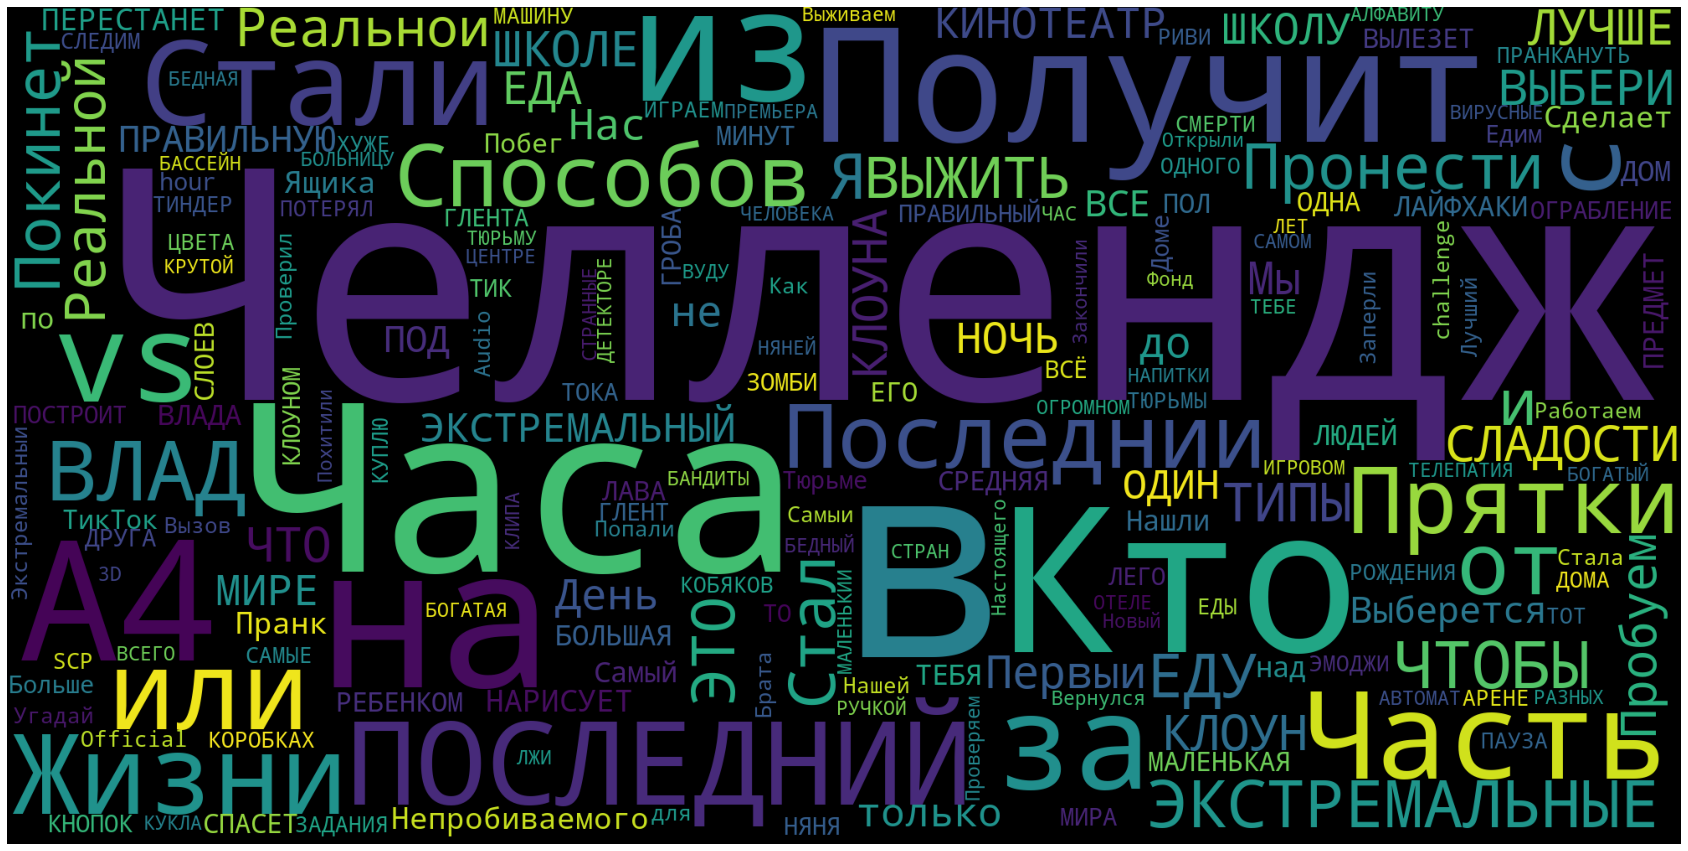

In [38]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

## Расписание загрузки видео

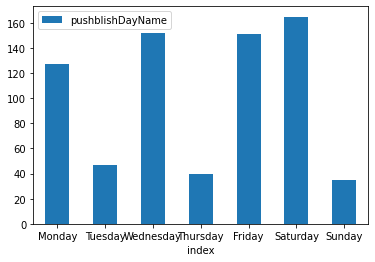

In [39]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

чаще всего видео были опубликованы в понедельник, среду, пятницу и субботу

# Проверка гипотез

## Повышают ли лайки и комментарии просмотры видео?

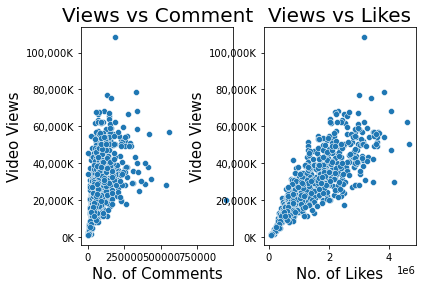

In [46]:
fig, ax =plt.subplots(1,2)
ax1 = sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0],  palette = 'ch:r=-0.8, l= 0.95')
ax2 = sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1], palette = 'ch:r=-0.8, l= 0.95')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))
ax1.set_ylabel('Video Views', size = 15)
ax2.set_ylabel('Video Views', size = 15)
ax1.set_xlabel('No. of Comments', size = 15)
ax2.set_xlabel('No. of Likes', size = 15)
ax1.set_title("Views vs Comment", size = 20)
ax2.set_title("Views vs Likes", size = 20)
plt.show()

график А: количество просмотров не является основным фактором, влияющим на количество комментариев, так как видео с большим количеством просмотров может собрать как много комментариев, так и не очень много. В основном количество комментариев до 250 тыс.
график Б: есть положительная линейная зависимоть между количеством просмотров и лайками. Однако, чем больше просмотров, тем слабее эта связь. Чем больше просмотров на видео, тем больше лайков и чем больше набирает лайков, тем больше ЮТ рекомендует

## Имеет ли влияние продолжительность видео на популярность?

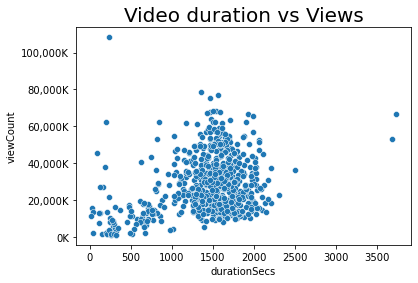

In [41]:
ax = sns.scatterplot(data = video_df, x = 'durationSecs', y = 'viewCount')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))
plt.title('Video duration vs Views', size = 20)
plt.show()

Наибольшее число прсмотров набирают видео продолжтьельностью от 16 минут(1 тыс. сек)

## Влияет ли продолжительность видео на количество лайков и комментариев?

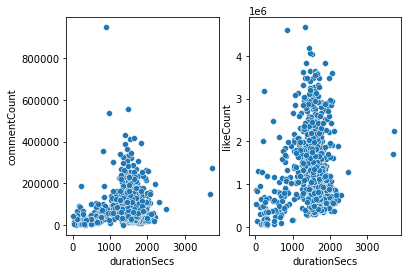

In [51]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])
plt.show()

Зависимость комментариев от продолжительности видео есть. Больше всего комментариев оставляют под видео длительностью 25 минут(1500 сек). То же самое и с количеством лайков

## Имеет ли значение день загрузки?

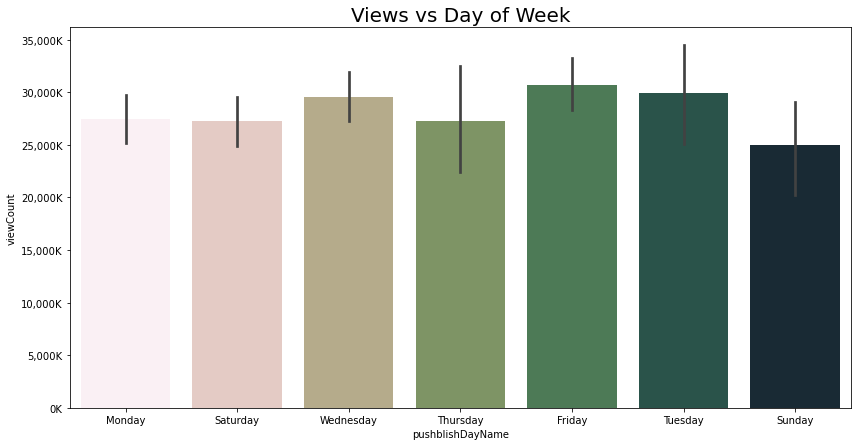

In [43]:
plt.figure(figsize=(14,7))
ax = sns.barplot(data = video_df, x = 'pushblishDayName', y = 'viewCount', palette = 'ch:r=-0.8, l= 0.95')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))
plt.title('Views vs Day of Week', size = 20)
plt.show()

In [44]:
df2 = video_df.copy()
df2['month_published'] = df2['publishedAt'].dt.month
df2 = df2.set_index('month_published').sort_index()
df2['month_name'] = df2['publishedAt'].dt.month_name()

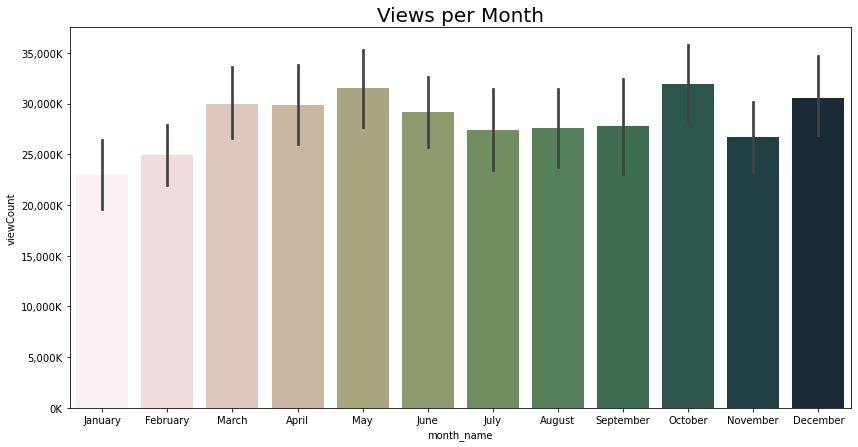

In [45]:
plt.figure(figsize=(14,7))
ax = sns.barplot(data = df2, x = 'month_name', y = 'viewCount', palette = 'ch:r=-0.8, l= 0.95')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))
plt.title('Views per Month', size = 20)
plt.show()

# Выводы

Для разработки стратегии YouTube канала важно знать свою нишу и понимать что и как влияет на популярность видео. Используя эти данные можно планировать, например, размещение нативной или встроенной рекламы в видео. Особенно это актуально, когда в России отключена монетизация.

- Основная аудитория канала - дети. У меня было предположение о том, что количество просмотров может иметь сезонную цикличномть и также зависимость от дня недели. Однако, распределение просмотров по дням недели является более или менее равномерным, в дни публикации видео просмотров чуть больше. А сезонная цикличность говорит о том, что выпущенные в январе видео набирают меньше всего просмотров и больше всего просмотров в октябре. 

- Наибольшее число прсмотров набирают видео продолжительностью от 16 минут
- Количество просмотров не является основным фактором, влияющим на количество комментариев, так как видео с большим количеством просмотров может собрать как много комментариев, так и не очень много.
- Есть положительная линейная зависимоть между количеством просмотров и лайками. Однако, чем больше просмотров, тем слабее эта связь. Чем больше просмотров на видео, тем больше лайков и чем больше набирает лайков, тем больше ЮТ рекомендует